In [80]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
# Utility function to report best scores
def report(results, n_top=3):
    """Utility function to report best scores
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print("Score: {0:f} (std: {1:f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Pars: {0}".format(results['params'][candidate]))
            print("")
            

def report2(results, n_top=3):
    """Utility function to report best scores
    """
    print("Rank|Score(std)|Params", list(results['params'][0].keys()))
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("{0}|".format(i), end="")
            print("{0:f}(std:{1:f})|".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]), end="")
            print("{0}".format(list(results['params'][candidate].values())))

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

----
# modify features

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [4]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

## make Cabin First character feature

In [5]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

### make one Cabin_Letter feature by numerical

### make dummy variable for Cabin_Letter

In [6]:
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(1309, 14)
(891, 22) (418, 21)


**if you made Cabin_num features too, duplicate feature for NaN. delete one of these**

In [7]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Len,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,9,1,0,0,0,0,0,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,8,0,0,0,1,0,0,0,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,16,1,0,0,0,0,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,6,0,0,0,1,0,0,0,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,6,1,0,0,0,0,0,0,0,0


In [8]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Len',
       'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C',
       'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G',
       'Cabin_Letter_T'],
      dtype='object')

In [9]:
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Len,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,...,6,1,0,0,0,0,0,0,0,0
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,...,6,1,0,0,0,0,0,0,0,0
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,...,6,1,0,0,0,0,0,0,0,0
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,...,6,1,0,0,0,0,0,0,0,0
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,...,7,1,0,0,0,0,0,0,0,0


## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

**CabinBool is inclueded in Cabin letter and cabin number**
**no need to use**

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [10]:
for i in [train_df, test_df]:
    i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num1'].replace('an', np.NaN, inplace = True)
    i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
    i['Cabin_num'] = pd.qcut(train_df['Cabin_num1'], 3)
    i['Cabin_num'] = i['Cabin_num'].cat.add_categories(["nan_category"])
    i['Cabin_num'] = i['Cabin_num'].fillna("nan_category")

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

In [11]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix='Cabin_num')), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix='Cabin_num')), axis = 1)

In [12]:
del train_df['Cabin_num']
del test_df['Cabin_num']
del train_df['Cabin_num1']
del test_df['Cabin_num1']

## del Ticket, Cabin columns

In [13]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

## add title

In [14]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

## make name length feature

In [15]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

## map value to Sex 

In [16]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

## make Age_Null_Flag if the Age is nulll

In [17]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

## fill na of Age

options

- by Sex and Pclass
- by Title and Pclass

### by Sex and Pclass

### fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I modified.

In [18]:
train_test_df = pd.concat((train_df, test_df))
groupedAge_train_test = train_test_df.groupby(['Title', 'Pclass'])['Age']
train_test_df.Age = groupedAge_train_test.transform(lambda x:x.fillna(x.mean()))

groupedByTitleOnly_Age_train_test = train_test_df.groupby(['Title'])['Age']
train_test_df.Age = groupedByTitleOnly_Age_train_test.transform(lambda x:x.fillna(x.mean()))

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

combine = [train_df, test_df]
test_df = test_df.drop(["Survived"], axis=1)

In [19]:
train_test_df.Age.isna().any()

False

In [20]:
train_df.shape, test_df.shape

((891, 27), (418, 26))

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

#### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

### add age band

- 5 age band by pd.cut
- 10 age band by pd.cut: this is better score.

if i use pd.qcut, band become too short for young adult around 25.

In [21]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [22]:
# 5 age band
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


----

## convert Title to numerical or one hot encoding

several options

- one hot encoding, no deleting rare title
- change rare title to "Rare" and map value
- change rare title to "Rare" and one hot encoding

### one hot encoding, no deleteing rare title

### OR change rare title to "Rare" and map value

**del rare title and map value**

**Replacing rare titles with more common ones**

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/

### change rare title to "Rare" and one hot encoding

In [23]:
mapping = {'Mlle': 'Miss', 
            'Major': 'Mr', 
            'Col': 'Mr', 
            'Sir': 'Mr',
            'Don': 'Mr', 
            'Mme': 'Miss',
            'Jonkheer': 'Mr',
            'Lady': 'Mrs', 
            'Capt': 'Mr', 
            'Countess': 'Mrs',
            'Ms': 'Miss',
            'Dona': 'Mrs'}

train_df.replace({'Title': mapping}, inplace=True)
test_df.replace({'Title': mapping}, inplace=True)

combine = [train_df, test_df]

train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 32) (418, 31)


In [24]:
train_df.columns

Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Cabin_num_nan_category', 'Embarked',
       'Fare', 'Name', 'Name_Len', 'Parch', 'PassengerId', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket_Len', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev'],
      dtype='object')

## Create new feature "FamilySize"

In [25]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [26]:
# keep FamilySize only

train_df = train_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Survived,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,FamilySize,Age*Class
0,1.0,0,1,0,0,0,0,0,0,0,...,0.0,9,0,0,0,1,0,0,2,3.0
1,2.0,0,0,0,0,1,0,0,0,0,...,1.0,8,0,0,0,0,1,0,2,2.0
2,1.0,0,1,0,0,0,0,0,0,0,...,1.0,16,0,0,1,0,0,0,1,3.0
3,2.0,0,0,0,0,1,0,0,0,0,...,1.0,6,0,0,0,0,1,0,2,2.0
4,2.0,0,1,0,0,0,0,0,0,0,...,0.0,6,0,0,0,1,0,0,1,6.0


## fill missing Embarked 

In [27]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

## Converting Embarked categorical feature to numeric

## try one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [28]:
# try one hote encoding for Embarked
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

print(train_df.shape, test_df.shape)

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)

combine = [train_df, test_df]

(891, 32) (418, 31)
(1309, 32)
(891, 34) (418, 34)


In [29]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


## fill na of test data Fare

In [30]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [31]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,34.5,103.5,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,47.0,141.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,62.0,124.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,27.0,81.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,22.0,66.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


In [32]:
train_df.Fare.isna().any()

False

## make Fareband feature

In [33]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    #print(dataset['Fare'].value_counts())
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

## drop Name, PassengerId

In [34]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

## final check data

In [35]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [36]:
train_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Cabin_num_nan_category', 'FamilySize',
       'Fare', 'Name_Len', 'Pclass', 'Sex', 'Survived', 'Ticket_Len',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [37]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,34.5,103.5,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,47.0,141.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,62.0,124.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,27.0,81.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,22.0,66.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


In [38]:
test_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Cabin_num_nan_category', 'FamilySize',
       'Fare', 'Name_Len', 'PassengerId', 'Pclass', 'Sex', 'Ticket_Len',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

----
# try to delete some features

- Age*Class is duplicated. Age and Pclass is enough, i think

- Name_Len looks no meaning

- Ticket_Len looks no meaning

- Cabin_Num looks no meaning. Cabin null feature is included in Cabinb_Letter value.

In [39]:
train_df = train_df.drop(['Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
                          'Cabin_num_(65.667, 148.0]', 'Cabin_num_nan_category'], axis=1)
test_df = test_df.drop(['Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
                        'Cabin_num_(65.667, 148.0]', 'Cabin_num_nan_category'], axis=1)

In [40]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(891, 28) (418, 28)
Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'FamilySize',
       'Fare', 'Name_Len', 'Pclass', 'Sex', 'Survived', 'Ticket_Len',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object') Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'FamilySize',
       'Fare', 'Name_Len', 'PassengerId', 'Pclass', 'Sex', 'Ticket_Len',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [41]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [42]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,34.5,103.5,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,47.0,141.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,62.0,124.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,27.0,81.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,22.0,66.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


----

# model and estimate

In [43]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)
# 33, 

train/test data shape (596, 27) (295, 27)


----

## SVC

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 538 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.9s finished


best parameters: {'svc__C': 50, 'svc__gamma': 0.005}
Mean cross-validated score of the best_estimator:  0.8104026845637584
test:  0.8338983050847457
confusion matrix:  [[153  22]
 [ 27  93]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.810403(std:0.043595)|[50, 0.005]
2|0.808725(std:0.041914)|[30, 0.005]
2|0.808725(std:0.035353)|[30, 0.008]
4|0.807047(std:0.056899)|[70, 0.001]
5|0.805369(std:0.026122)|[30, 0.01]
5|0.805369(std:0.037763)|[100, 0.005]
7|0.802013(std:0.034252)|[50, 0.01]
7|0.802013(std:0.030320)|[70, 0.005]
7|0.802013(std:0.038957)|[70, 0.008]
7|0.802013(std:0.056624)|[80, 0.001]
7|0.802013(std:0.039735)|[80, 0.008]
7|0.802013(std:0.053525)|[90, 0.001]
7|0.802013(std:0.057796)|[100, 0.001]


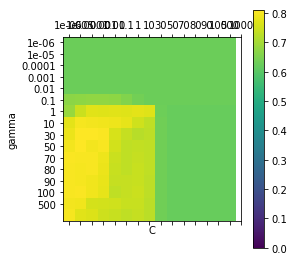

In [45]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, minmax scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.3s finished


best parameters: {'svc__C': 90, 'svc__gamma': 0.04}
Mean cross-validated score of the best_estimator:  0.8389261744966443
test:  0.8067796610169492
confusion matrix:  [[153  22]
 [ 35  85]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.838926(std:0.045398)|[90, 0.04]
2|0.837248(std:0.042458)|[30, 0.1]
2|0.837248(std:0.045470)|[50, 0.05]
2|0.837248(std:0.044912)|[70, 0.04]
2|0.837248(std:0.045470)|[80, 0.04]
6|0.835570(std:0.042570)|[50, 0.04]
6|0.835570(std:0.042570)|[90, 0.03]
6|0.835570(std:0.042570)|[100, 0.03]
9|0.833893(std:0.045401)|[10, 0.1]
9|0.833893(std:0.043821)|[70, 0.05]
9|0.833893(std:0.043047)|[90, 0.05]
9|0.833893(std:0.043821)|[100, 0.04]
9|0.833893(std:0.043047)|[100, 0.05]


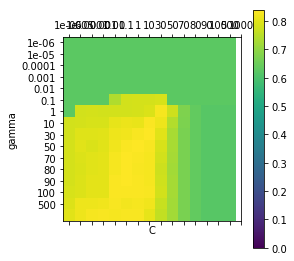

In [46]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(MinMaxScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, robust scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 554 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.8s finished


best parameters: {'svc__C': 80, 'svc__gamma': 0.01}
Mean cross-validated score of the best_estimator:  0.8238255033557047
test:  0.8135593220338984
confusion matrix:  [[151  24]
 [ 31  89]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.823826(std:0.041472)|[80, 0.01]
2|0.822148(std:0.038588)|[90, 0.01]
2|0.822148(std:0.034783)|[100, 0.01]
4|0.818792(std:0.038530)|[50, 0.01]
4|0.818792(std:0.041423)|[70, 0.01]
4|0.818792(std:0.026140)|[500, 0.005]
7|0.817114(std:0.042016)|[80, 0.008]
8|0.815436(std:0.044427)|[70, 0.008]
8|0.815436(std:0.037683)|[100, 0.008]
8|0.815436(std:0.023007)|[1000, 0.005]


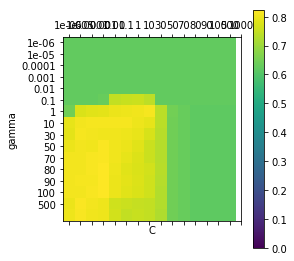

In [47]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(RobustScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, StandardScaler scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.5s finished


best parameters: {'svc__C': 70, 'svc__gamma': 0.01}
Mean cross-validated score of the best_estimator:  0.837248322147651
test:  0.8101694915254237
confusion matrix:  [[155  20]
 [ 36  84]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.837248(std:0.027931)|[70, 0.01]
1|0.837248(std:0.032449)|[80, 0.008]
1|0.837248(std:0.027931)|[80, 0.01]
1|0.837248(std:0.027931)|[90, 0.008]
1|0.837248(std:0.028431)|[90, 0.01]
1|0.837248(std:0.027931)|[100, 0.008]
7|0.835570(std:0.030271)|[50, 0.01]
8|0.833893(std:0.024637)|[100, 0.01]
8|0.833893(std:0.031526)|[500, 0.005]
8|0.833893(std:0.033322)|[1000, 0.005]


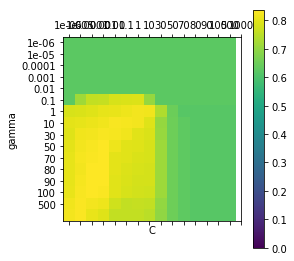

In [48]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

----

## KNeighborsClassifier

In [49]:
# no cale
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 3}
Mean cross-validated score of the best_estimator:  0.738255033557047
test:  0.7559322033898305
confusion matrix:  [[149  26]
 [ 46  74]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.738255(std:0.044906)|[3]
2|0.721477(std:0.033512)|[15]
3|0.719799(std:0.029573)|[4]
4|0.718121(std:0.040301)|[5]
5|0.716443(std:0.038271)|[7]
5|0.716443(std:0.036525)|[8]
7|0.714765(std:0.032499)|[9]
8|0.711409(std:0.025595)|[2]
9|0.709732(std:0.035195)|[10]
9|0.709732(std:0.037208)|[20]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### minmax scaler

In [50]:
# minmax scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 10}
Mean cross-validated score of the best_estimator:  0.8322147651006712
test:  0.8169491525423729
confusion matrix:  [[160  15]
 [ 39  81]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.832215(std:0.047259)|[10]
2|0.823826(std:0.029742)|[3]
3|0.822148(std:0.031120)|[5]
4|0.820470(std:0.024786)|[4]
5|0.818792(std:0.042926)|[7]
5|0.818792(std:0.049013)|[9]
7|0.813758(std:0.038111)|[8]
8|0.810403(std:0.043168)|[15]
9|0.808725(std:0.028541)|[6]
10|0.802013(std:0.028255)|[20]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


### robust scaler

In [51]:
# robust scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(RobustScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 3}
Mean cross-validated score of the best_estimator:  0.7751677852348994
test:  0.7728813559322034
confusion matrix:  [[143  32]
 [ 35  85]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.775168(std:0.045210)|[3]
2|0.773490(std:0.031206)|[5]
3|0.771812(std:0.025749)|[7]
4|0.763423(std:0.032214)|[6]
5|0.761745(std:0.037883)|[8]
6|0.760067(std:0.032154)|[20]
7|0.756711(std:0.036260)|[15]
8|0.755034(std:0.033617)|[9]
9|0.753356(std:0.030124)|[4]
10|0.739933(std:0.030897)|[10]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### StandardScaler

In [52]:
# StandardScaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 5}
Mean cross-validated score of the best_estimator:  0.8036912751677853
test:  0.8101694915254237
confusion matrix:  [[155  20]
 [ 36  84]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.803691(std:0.026871)|[5]
2|0.802013(std:0.015004)|[3]
3|0.800336(std:0.014410)|[4]
3|0.800336(std:0.032265)|[7]
5|0.798658(std:0.030958)|[8]
5|0.798658(std:0.033298)|[15]
7|0.793624(std:0.023551)|[9]
8|0.791946(std:0.026558)|[6]
8|0.791946(std:0.029382)|[10]
10|0.786913(std:0.039260)|[20]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


----

# random forest result for compare

**normal**

In [53]:
"""
# too wide
param_grid = {'randomforestclassifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25 None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2', None],
             'randomforestclassifier__min_samples_leaf': [1,2,3,4,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7],
             'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
              }
"""
# narrow down
param_grid = {'randomforestclassifier__max_depth':[5, 7, 8, 9,  13, 15, 20, 25, None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2'],
#             'randomforestclassifier__min_samples_leaf': [1,2,3 ,5],
             "randomforestclassifier__min_samples_split" : [2,3, 5,6,7],
             'randomforestclassifier__n_estimators': [20, 30, 40,  60, 100],
              }
pipe = make_pipeline(RandomForestClassifier())

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 1420 tasks      | elapsed:   18.0s


best parameters: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 60}
Mean cross-validated score of the best_estimator:  0.8406040268456376
test:  0.8338983050847457
confusion matrix:  [[158  17]
 [ 32  88]]

Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.840604(std:0.036468)|[7, 'log2', 6, 60]
2|0.837248(std:0.034510)|[9, 'log2', 6, 40]
3|0.835570(std:0.032769)|[7, 'log2', 5, 60]
3|0.835570(std:0.030142)|[7, 'log2', 7, 20]
5|0.833893(std:0.035607)|[8, 1, 2, 30]
5|0.833893(std:0.039170)|[8, 1, 5, 60]
5|0.833893(std:0.026718)|[8, 'log2', 5, 40]
5|0.833893(std:0.029716)|[9, 1, 7, 100]
9|0.832215(std:0.035281)|[5, 'log2', 6, 100]
9|0.832215(std:0.034061)|[7, 1, 2, 40]
9|0.832215(std:0.023301)|[7, 1, 3, 100]
9|0.832215(std:

[Parallel(n_jobs=6)]: Done 3375 out of 3375 | elapsed:   43.8s finished


In [54]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
21,Title_Mr,0.185833
16,Sex,0.141768
14,Name_Len,0.102910
15,Pclass,0.085648
12,FamilySize,0.055991
22,Title_Mrs,0.052285
13,Fare,0.051910
20,Title_Miss,0.050405
17,Ticket_Len,0.045878
3,Cabin_Letter_0,0.042707


In [55]:
pipe.fit(X_train_df, y_train_df)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = pipe.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_randomforest.csv', index=False)

**just trial of PolynomialFeatures(degree=2)**

In [56]:
"""
# too wide
param_grid = {'randomforestclassifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25 None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2', None],
             'randomforestclassifier__min_samples_leaf': [1,2,3,4,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7],
             'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
              }
"""
# narrow down
param_grid = {'randomforestclassifier__max_depth':[5, 7, 8, 9,  13, 15, 20, 25, None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2'],
#             'randomforestclassifier__min_samples_leaf': [1,2,3 ,5],
             "randomforestclassifier__min_samples_split" : [2,3, 5,6,7],
             'randomforestclassifier__n_estimators': [20, 30, 40,  60, 100],
              }
pipe = make_pipeline(PolynomialFeatures(degree=2), RandomForestClassifier())

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 1420 tasks      | elapsed:   23.5s


best parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 7, 'randomforestclassifier__n_estimators': 30}
Mean cross-validated score of the best_estimator:  0.8389261744966443
test:  0.8271186440677966
confusion matrix:  [[155  20]
 [ 31  89]]

Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.838926(std:0.023982)|[None, 'sqrt', 7, 30]
2|0.837248(std:0.029837)|[7, 'sqrt', 6, 60]
2|0.837248(std:0.030703)|[7, 'log2', 7, 100]
4|0.835570(std:0.045299)|[5, 'sqrt', 5, 40]
4|0.835570(std:0.025515)|[7, 1, 2, 100]
6|0.833893(std:0.036707)|[5, 'sqrt', 2, 100]
6|0.833893(std:0.040738)|[5, 'log2', 6, 60]
6|0.833893(std:0.035043)|[7, 'log2', 5, 100]
6|0.833893(std:0.028822)|[8, 'sqrt', 6, 60]
6|0.833893(std:0.024795)|[None, 1, 6, 60]


[Parallel(n_jobs=6)]: Done 3375 out of 3375 | elapsed:   57.7s finished


In [57]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
17,Ticket_Len,0.051656
295,NaN,0.042764
329,NaN,0.042301
322,NaN,0.032538
290,NaN,0.028340
296,NaN,0.021577
355,NaN,0.019594
316,NaN,0.019229
44,NaN,0.019134
22,Title_Mrs,0.019031


----

## XGBoost

----

## AdaBoostClassifier

----

## GradientBoostingClassifier

In [58]:
"""
# too wide
param_grid = {'learning_rate': [0.001, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
              'max_depth':[1,2,3,4,5,6,7,8],
              'max_features': [None, 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6],
              'min_samples_split':[2, 3, 4, 5, 6],
              'n_estimators': [3, 5, 7, 10, 50, 100, 200, 300, 400, 500],
              }
"""

# narrow in specific region
param_grid = {'learning_rate': [0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
              'max_depth':[3,4,5,6,7],
              'max_features': [None, 'sqrt', 'log2'],
#              'min_samples_leaf': [1, 2, 3, 4, 5],
              'min_samples_split':[2, 3, 4, 5, 6],
              'n_estimators': [7, 10, 50, 100, 200, 300, 400, 500],
              }

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


[Parallel(n_jobs=6)]: Done 366 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 872 tasks      | elapsed:   23.7s
[Parallel(n_jobs=6)]: Done 1372 tasks      | elapsed:   42.1s
[Parallel(n_jobs=6)]: Done 1978 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2428 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 2978 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4198 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5294 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 6231 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 8009 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 9097 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 11136 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 12715 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 14707 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 17073 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 19348 tasks      | elapsed: 14.8min


best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
Mean cross-validated score of the best_estimator:  0.8439597315436241
test:  0.8271186440677966
confusion matrix:  [[158  17]
 [ 34  86]]

Rank|Score(std)|Params ['learning_rate', 'max_depth', 'max_features', 'min_samples_split', 'n_estimators']
1|0.843960(std:0.027599)|[0.2, 5, 'log2', 2, 10]
2|0.840604(std:0.028880)|[0.2, 5, 'log2', 6, 10]
3|0.838926(std:0.029746)|[0.005, 5, 'log2', 3, 400]
3|0.838926(std:0.033294)|[0.007, 5, 'log2', 2, 300]
3|0.838926(std:0.035046)|[0.01, 4, 'log2', 3, 300]
3|0.838926(std:0.036377)|[0.02, 4, 'log2', 5, 200]
3|0.838926(std:0.043581)|[0.2, 4, 'sqrt', 2, 7]
8|0.837248(std:0.032774)|[0.005, 4, 'log2', 3, 400]
8|0.837248(std:0.028473)|[0.005, 5, 'sqrt', 5, 400]
8|0.837248(std:0.034388)|[0.007, 4, 'log2', 5, 400]
8|0.837248(std:0.033632)|[0.007, 5, 'sqrt', 3, 300]
8|0.837248(std:0.031074)|[0.007, 5, 'log2', 6, 400]
8|0.837248(std:0.0

[Parallel(n_jobs=6)]: Done 21000 out of 21000 | elapsed: 16.1min finished


In [59]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
16,Sex,0.192051
21,Title_Mr,0.121513
14,Name_Len,0.108247
17,Ticket_Len,0.084978
12,FamilySize,0.075229
15,Pclass,0.067792
3,Cabin_Letter_0,0.057716
1,Age*Class,0.046907
0,Age,0.039551
13,Fare,0.035144


**for submit, make model by best par and fit to all train data**

In [60]:
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.05,
                                                max_depth=4,
                                                max_features="sqrt",
#                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=50))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, pipe.predict(X_test)))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())

test:  0.847457627118644
confusion matrix:  [[161  14]
 [ 31  89]]
mean of cross val score for X_train_df:  0.8294051627384961


In [61]:
pipe.fit(X_train_df, y_train_df)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = pipe.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_gradientboosting.csv', index=False)

In [62]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
21,Title_Mr,0.187533
16,Sex,0.152978
15,Pclass,0.099926
14,Name_Len,0.092986
12,FamilySize,0.076732
1,Age*Class,0.060303
17,Ticket_Len,0.045691
3,Cabin_Letter_0,0.043553
13,Fare,0.037702
22,Title_Mrs,0.037282


**just trial of PolynomialFeatures(degree=2)**

In [63]:
pipe = make_pipeline(PolynomialFeatures(degree=2), 
                     GradientBoostingClassifier(learning_rate=0.05,
                                                max_depth=4,
                                                max_features="sqrt",
#                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=50))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, pipe.predict(X_test)))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())


test:  0.8338983050847457
confusion matrix:  [[159  16]
 [ 33  87]]
mean of cross val score for X_train_df:  0.8249158249158248


In [64]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
317,NaN,0.044893
355,NaN,0.035729
339,NaN,0.034170
341,NaN,0.028036
315,NaN,0.027475
124,NaN,0.025726
16,Sex,0.025422
329,NaN,0.024538
318,NaN,0.024142
22,Title_Mrs,0.023723


** polynominal and pca**

In [112]:
pipe = make_pipeline(PolynomialFeatures(degree=2, interaction_only=False),
                     GradientBoostingClassifier(learning_rate=0.05,
                                                max_depth=4,
                                                max_features="sqrt",
#                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=50))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, pipe.predict(X_test)))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())


test:  0.8338983050847457
confusion matrix:  [[158  17]
 [ 32  88]]
mean of cross val score for X_train_df:  0.8237934904601572


In [84]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
337,NaN,0.045984
307,NaN,0.039664
69,NaN,0.027731
302,NaN,0.026935
318,NaN,0.025195
324,NaN,0.025063
301,NaN,0.023822
290,NaN,0.022886
303,NaN,0.022249
114,NaN,0.022057
